# llm_survey_eval — Demo: Full Pipeline (Tiers 1–4)

This notebook constructs **toy Human** and **toy LLM** datasets, then runs Tier‑1 (marginals), Tier‑2 (associations), Tier‑3 (joint metrics), and Tier‑4 (inferential equivalence).
Along the way, we add visual sanity checks: distribution plots for ordinal and nominal variables, a triptych of association matrices, and a 2‑D projection of the joint embedding.

> Tip: This repository is GitHub‑first at this stage. Install locally with `pip install -e .`.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.decomposition import PCA

from llm_survey_eval.tier1 import run_tier1_comparisons
from llm_survey_eval.tier2 import tier2_structural, plot_three
from llm_survey_eval.tier3 import compute_global_metrics, _embed
from llm_survey_eval.tier4 import evaluate_tier4, summarize_tier4, plot_forest_tier4

%matplotlib inline
plt.rcParams['figure.dpi'] = 140

# Ensure a local data folder exists
DATA_DIR = Path('data'); DATA_DIR.mkdir(exist_ok=True)

rng = np.random.default_rng(0)
N = 500  # sample size per dataset

ordered_features = [
    'shopping_frequency','leisure_frequency','service_frequency',
    'shopping_satisfaction','leisure_satisfaction','service_satisfaction'
]
nominal_features = ['shopping_mode','leisure_mode','service_mode']

# Construct toy HUMAN data
human = pd.DataFrame({'agent_id': np.arange(N)})
for c in ordered_features:
    human[c] = rng.integers(1, 7, size=N)  # integer 1..6
base_p = np.array([0.15,0.15,0.20,0.15,0.10,0.10,0.15])
cats = np.arange(1,8)
for c in nominal_features:
    human[c] = rng.choice(cats, size=N, p=base_p)

# Construct toy LLM data with mild shifts
llm = pd.DataFrame({'agent_id': np.arange(N)})
for c in ordered_features:
    base = human[c].astype(float) + 0.25*rng.normal(size=N)
    llm[c] = np.clip(np.rint(base), 1, 6).astype(int)
bias_p = np.array([0.10,0.14,0.22,0.18,0.14,0.10,0.12])
for c in nominal_features:
    llm[c] = rng.choice(cats, size=N, p=bias_p)

# Save to CSV for Tier‑1/Tier‑2 convenience wrappers
human_path = DATA_DIR/'sampled_data.csv'
llm_path   = DATA_DIR/'dsv3.csv'
human.to_csv(human_path)
llm.to_csv(llm_path)

#human.head(), llm.head()


## Visual sanity checks — Ordinal distributions

For each ordinal variable, we overlay the empirical distributions of Human vs LLM. Perfect overlap is unlikely in synthetic data; we expect small but systematic shifts.


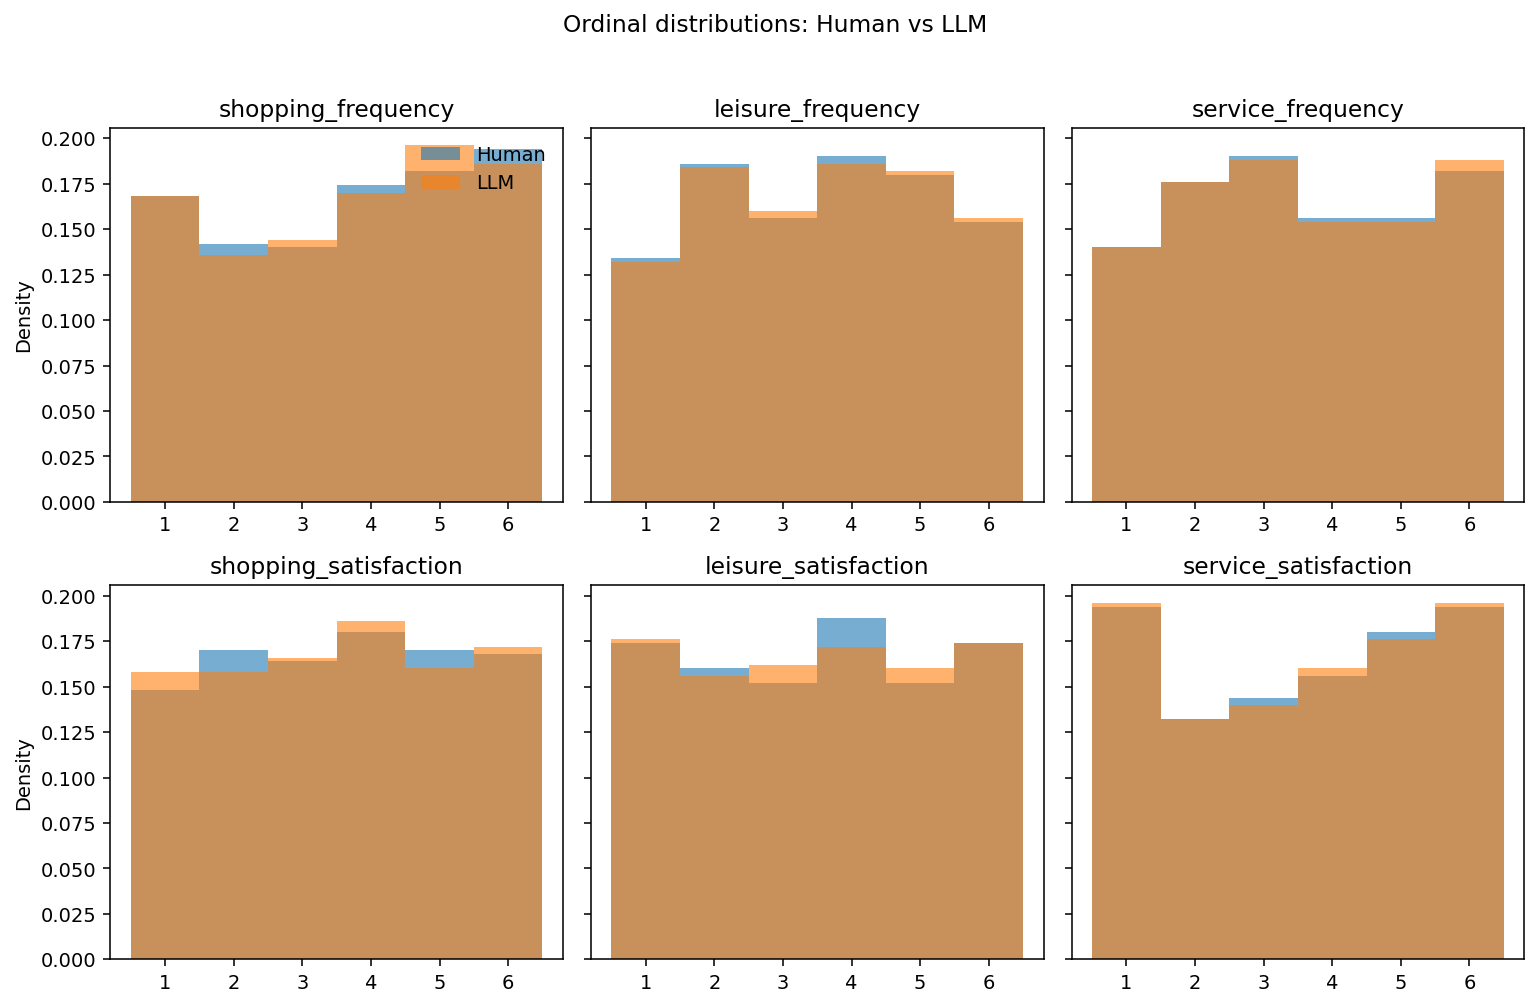

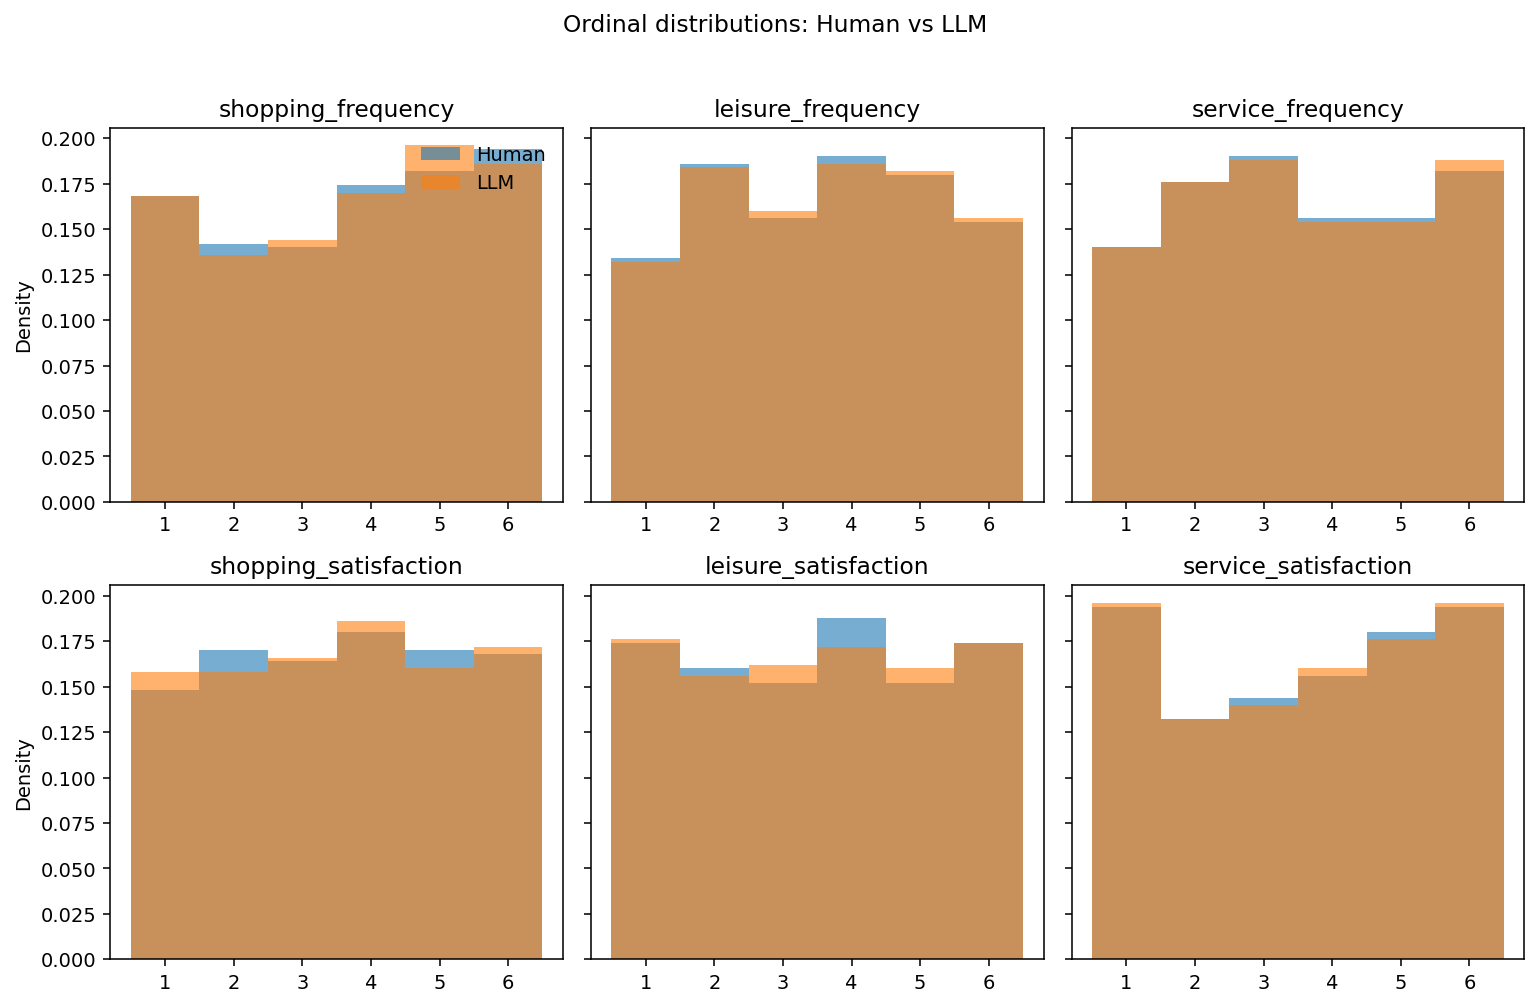

In [3]:
ncols = 3
nrows = int(np.ceil(len(ordered_features)/ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(11, 7), sharey=True)
axes = axes.ravel()
bins = np.arange(0.5, 6.6, 1.0)
for i, col in enumerate(ordered_features):
    ax = axes[i]
    ax.hist(human[col], bins=bins, alpha=0.6, label='Human', density=True)
    ax.hist(llm[col],   bins=bins, alpha=0.6, label='LLM',   density=True)
    ax.set_title(col)
    ax.set_xticks([1,2,3,4,5,6])
    if i % ncols == 0: ax.set_ylabel('Density')
axes[0].legend(frameon=False, loc='upper right')
for j in range(i+1, len(axes)):
    axes[j].axis('off')
fig.suptitle('Ordinal distributions: Human vs LLM', y=1.02)
fig.tight_layout()
fig


## Visual sanity checks — Nominal composition

We compare category proportions for each nominal variable; alignment uses the shared category set 1–7.


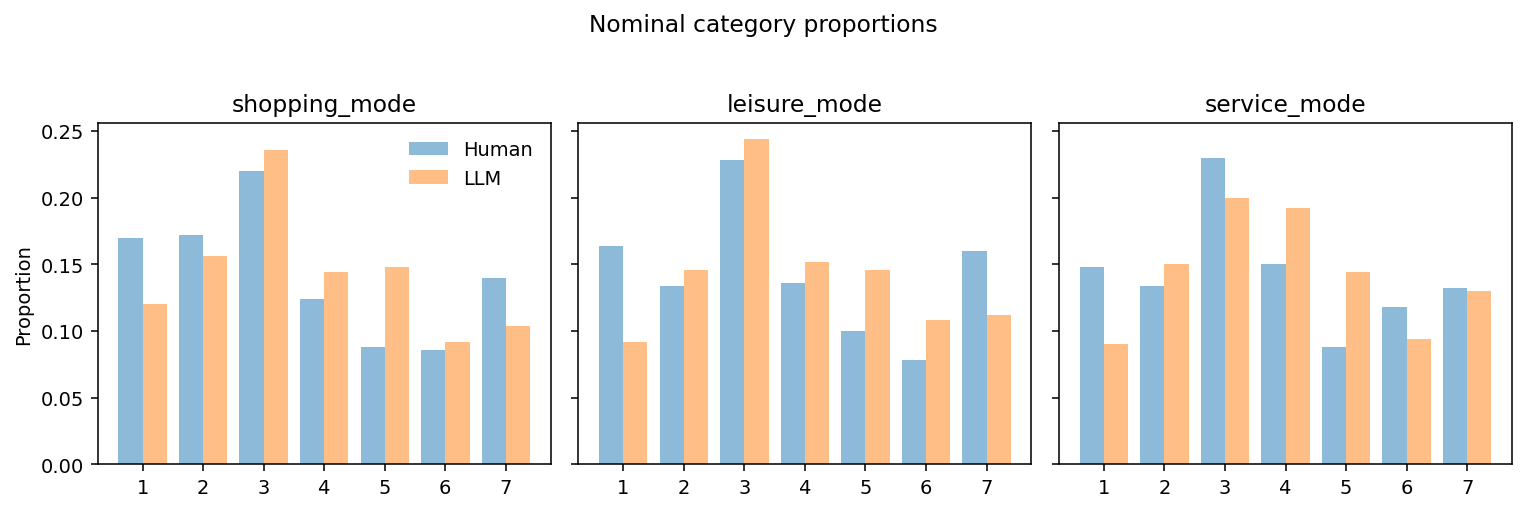

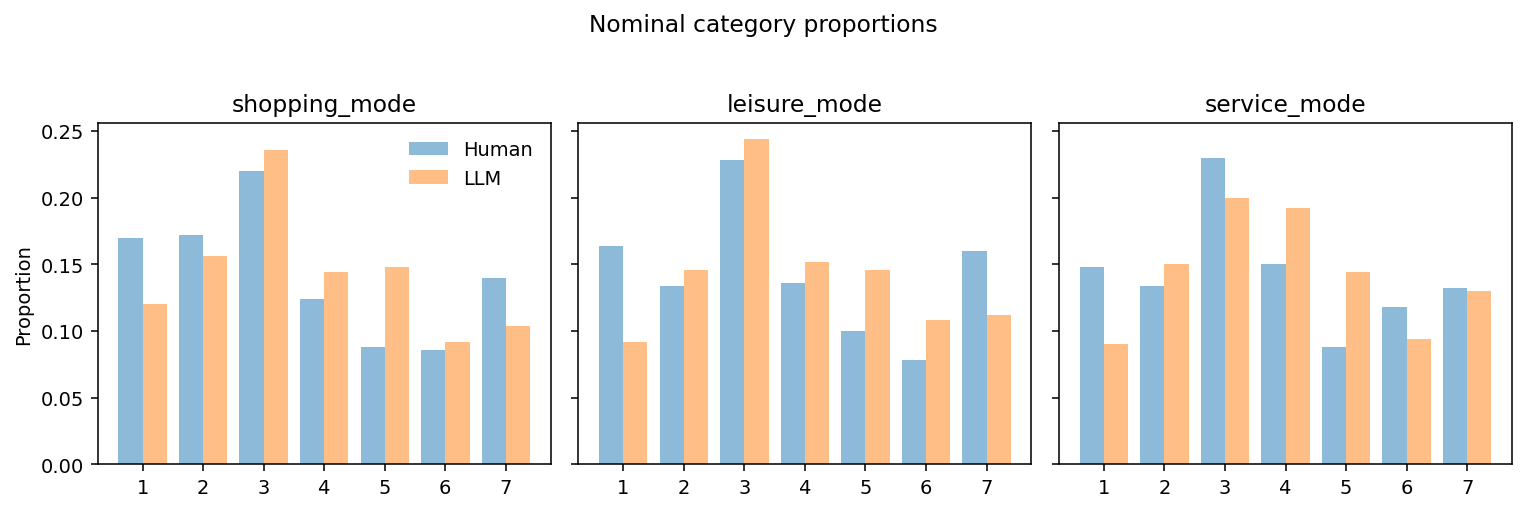

In [7]:
cats = np.arange(1,8)
ncols = 3; nrows = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(11, 3.5), sharey=True)
for i, col in enumerate(nominal_features):
    ax = axes[i]
    ph = human[col].value_counts(normalize=True).reindex(cats, fill_value=0).values
    pl = llm[col].value_counts(normalize=True).reindex(cats, fill_value=0).values
    x = np.arange(len(cats))
    w = 0.4
    ax.bar(x - w/2, ph, width=w, label='Human',alpha=0.5)
    ax.bar(x + w/2, pl, width=w, label='LLM',alpha=0.5)
    ax.set_xticks(x); ax.set_xticklabels([str(c) for c in cats])
    ax.set_title(col)
axes[0].set_ylabel('Proportion')
axes[0].legend(frameon=False, loc='upper right')
fig.suptitle('Nominal category proportions', y=1.03)
fig.tight_layout()
fig


# Tier‑1: Descriptive similarity (marginals)


In [8]:
tier1_out = run_tier1_comparisons(
    survey_csv=human_path,
    llm_csv=llm_path,
    ordered_features=ordered_features,
    multinomial_features=nominal_features,
    continuous_features=[],
    id_col='agent_id'
)
display(tier1_out.head(12))

,feature,type,n_survey,n_llm,support_k,TV,JS,chi2_stat,chi2_df,chi2_p,...,g_df,g_p,expected_min,W1,mean_s,mean_l,mean_diff_ratio,var_s,var_l,var_ratio_l_over_s
0,shopping_mode,nominal,500,500,7,0.102,0.011706,16.111539,6,0.013168,...,6,0.012580,44.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,leisure_mode,nominal,500,500,7,0.120,0.016050,22.053236,6,0.001184,...,6,0.001091,46.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,service_mode,nominal,500,500,7,0.114,0.014007,19.268135,6,0.003734,...,6,0.003514,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,shopping_frequency,ordinal,500,500,6,0.018,0.000332,0.459643,5,0.993527,...,5,0.993524,69.5,0.022,3.642,3.648,-0.001647,3.055948,3.022140,0.988937
4,leisure_frequency,ordinal,500,500,6,0.008,0.000052,0.071494,5,0.999929,...,5,0.999929,66.5,0.012,3.558,3.570,-0.003373,2.712060,2.710521,0.999433
5,service_frequency,ordinal,500,500,6,0.006,0.000048,0.066843,5,0.999940,...,5,0.999940,70.0,0.012,3.558,3.570,-0.003373,2.848333,2.878858,1.010717
6,shopping_satisfaction,ordinal,500,500,6,0.022,0.000442,0.613196,5,0.987391,...,5,0.987386,76.5,0.022,3.558,3.548,0.002811,2.828293,2.869435,1.014547
7,leisure_satisfaction,ordinal,500,500,6,0.020,0.000468,0.648386,5,0.985681,...,5,0.985673,78.0,0.020,3.506,3.506,0.000000,2.967900,2.987940,1.006752
8,service_satisfaction,ordinal,500,500,6,0.008,0.000062,0.086214,5,0.999887,...,5,0.999887,66.0,0.010,3.578,3.576,0.000559,3.202321,3.218661,1.005103


# Tier‑2: Behavioural association consistency (pairwise structure)

We compare the mixed‑type association matrices (Spearman/η/Cramér's V). The right panel shows LLM − Human differences.


C:\Users\11424\Downloads\LLM_Survey_Eval-main (3)\LLM_Survey_Eval-main\llm_survey_eval\tier2.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\11424\AppData\Local\Temp\ipykernel_23164\2947791574.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


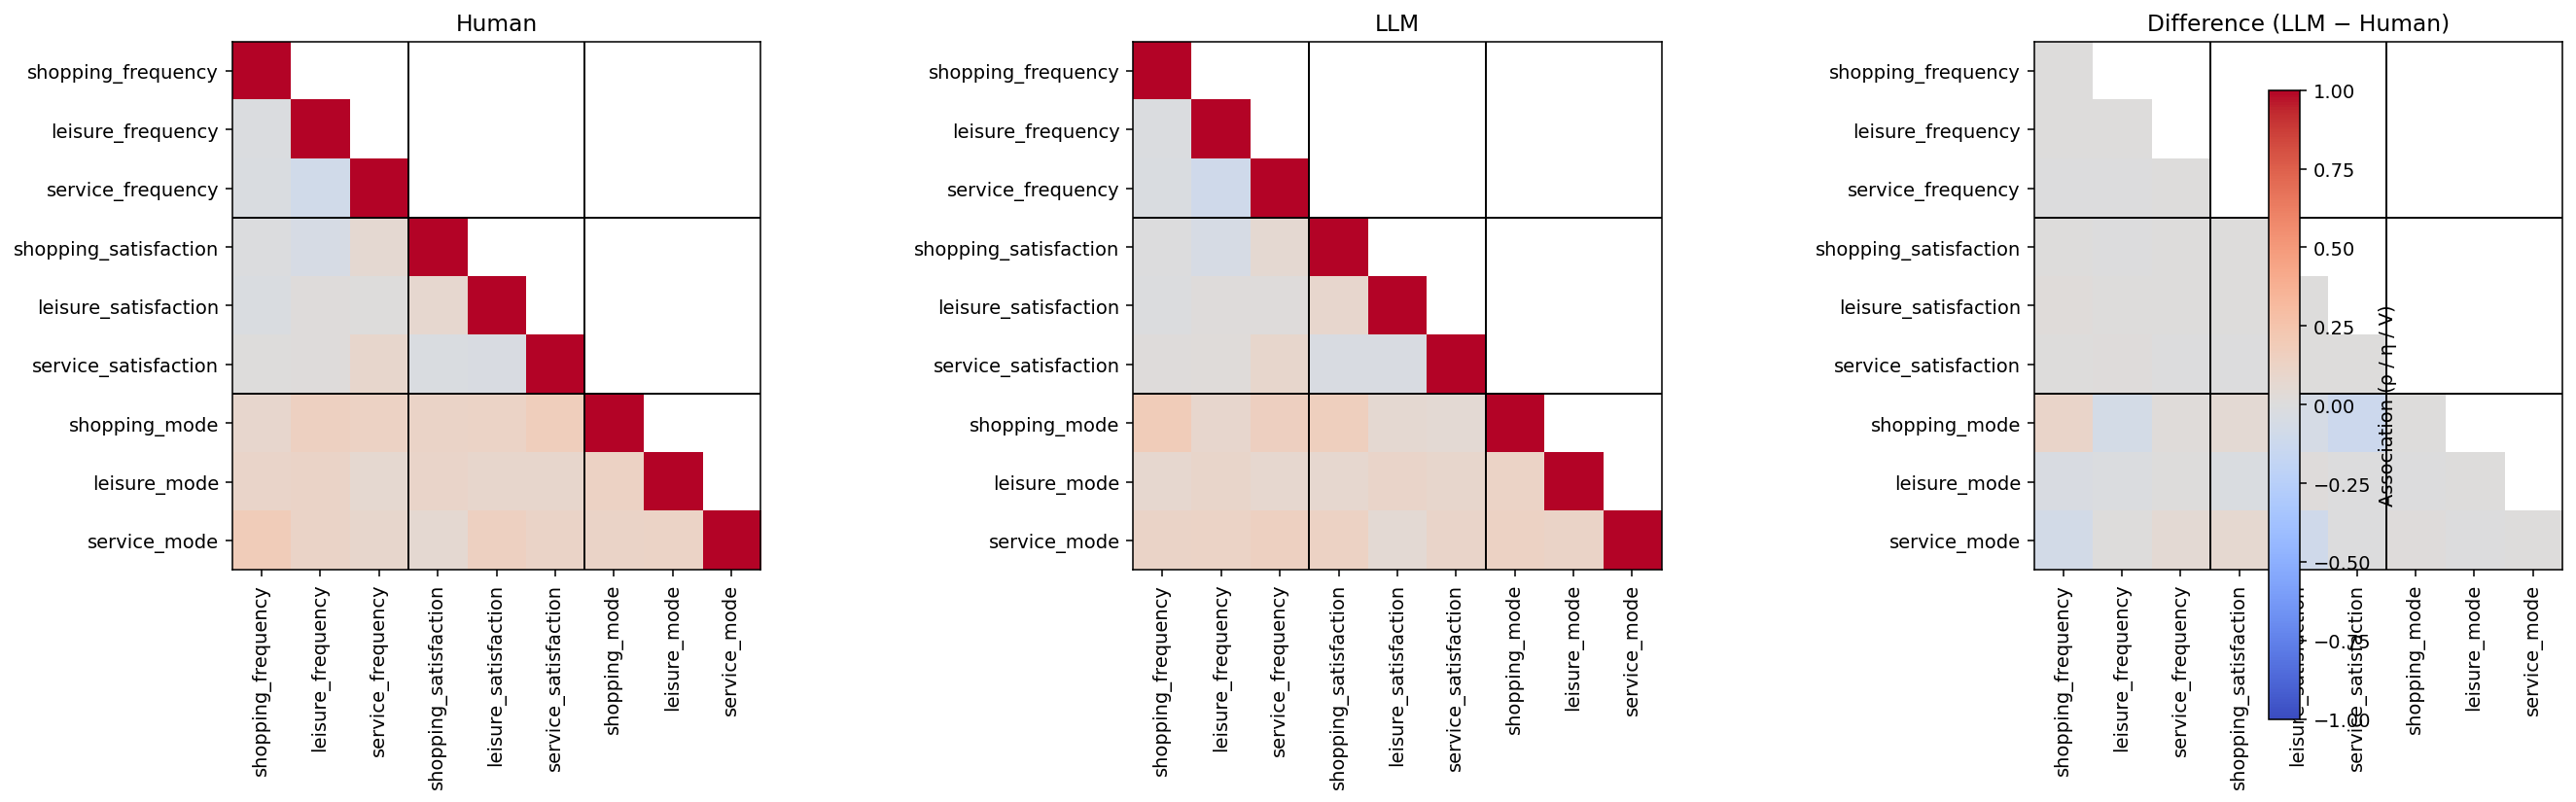

In [9]:
res2 = tier2_structural(
    human_path, llm_path,
    ordered_cols=ordered_features,
    nominal_cols=nominal_features,
    id_col='agent_id'
)
fig = plot_three(res2['assoc_h'], res2['assoc_l'], res2['assoc_diff'])
fig.tight_layout()


### Absolute difference heatmap

A quick view of |LLM − Human| helps identify the largest deviations.


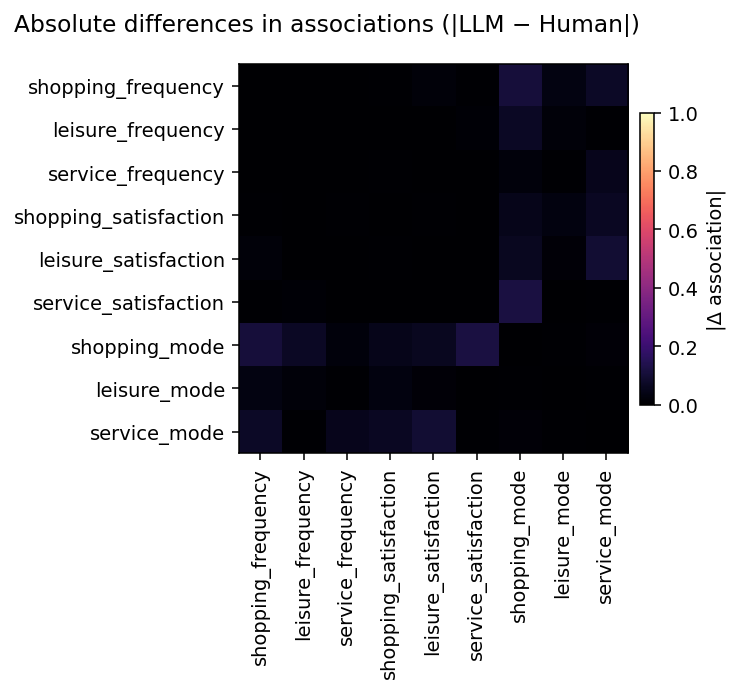

In [10]:
diff_abs = res2['assoc_diff'].abs()
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(diff_abs.values, vmin=0, vmax=1, cmap='magma')
ax.set_xticks(range(len(diff_abs.columns))); ax.set_xticklabels(diff_abs.columns, rotation=90)
ax.set_yticks(range(len(diff_abs.index)));  ax.set_yticklabels(diff_abs.index)
fig.colorbar(im, ax=ax, fraction=0.025, pad=0.02, label='|Δ association|')
fig.suptitle('Absolute differences in associations (|LLM − Human|)')
fig.tight_layout()


# Tier‑3: Multivariate behavioural fidelity (joint shape)

We embed (ordered → [0,1], nominal → one‑hot with fixed categories) and compute Energy distance (√ED²), Gaussian‑kernel MMD, and C2ST AUC.


In [14]:
nominal_categories = {c: [1,2,3,4,5,6,7] for c in nominal_features}
res3 = compute_global_metrics(
    human, llm,
    ordered_features=ordered_features,
    nominal_features=nominal_features,
    nominal_categories=nominal_categories,
    seed=42, verbose=False
)
res3


{'energy_distance': 0.1310016663818071,
 'mmd_gaussian': 0.03985659977722683,
 'mmd_bandwidth': 2.6076809620810595,
 'c2st_auc': 0.5554888888888889}

### 2‑D projection of the embedding (PCA)

A rough visual check: if Human and LLM clouds strongly separate in 2‑D, expect high C2ST AUC; if they overlap, AUC ~ 0.5.


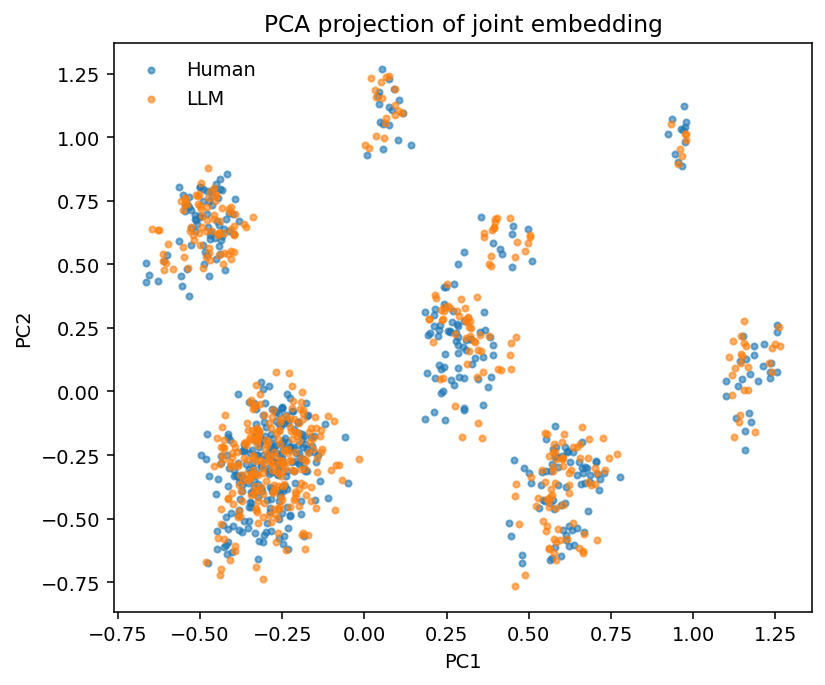

In [15]:
# Use internal _embed for a consistent map (ordered scaled, nominal one‑hot)
Xh = _embed(human, ordered_features, nominal_features, nominal_categories)
Xl = _embed(llm,   ordered_features, nominal_features, nominal_categories)
Z = np.vstack([Xh, Xl])
y = np.r_[np.zeros(len(Xh)), np.ones(len(Xl))]  # 0=Human, 1=LLM
pca = PCA(n_components=2, random_state=42).fit(Z)
Z2 = pca.transform(Z)
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(Z2[y==0,0], Z2[y==0,1], s=10, alpha=0.6, label='Human')
ax.scatter(Z2[y==1,0], Z2[y==1,1], s=10, alpha=0.6, label='LLM')
ax.set_title('PCA projection of joint embedding'); ax.legend(frameon=False)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); fig.tight_layout()


# Tier‑4: Inferential equivalence (Ordered / Multinomial Logit)
We compare coefficients between Human and LLM models using DCR (directional consistency) and SMR (significance matching) under a unified mixed‑type feature schema.

In [16]:
# 4.1 Define predictor schema (binary / continuous / ordinal / nominal)
feature_schema = {
 'gender': {'type': 'binary'},
 'income': {'type': 'continuous'},
 'season': {'type': 'nominal', 'categories': [1,2,3,4]},
}

# Create toy predictors compatible with the schema
for df in (human, llm):
    df['gender'] = rng.integers(0, 2, size=len(df))
    df['income'] = rng.normal(0, 1, size=len(df))
    df['season'] = rng.integers(1, 5, size=len(df))

# 4.2 Define outcomes: one ordered, one multinomial
outcomes = {
 'satisfaction_out': {'type': 'ordered', 'levels': [1,2,3,4,5]},
 'mode_out' : {'type': 'multinomial', 'levels': [1,2,3]},
}

# Build toy outcomes from latent utilities / thresholds for demonstration
def to_ord_latent(df):
    idx = 0.6*df['income'] + 0.4*df['gender'] + rng.normal(0, 1, size=len(df))
    cuts = [-np.inf, -0.4, 0.0, 0.5, 1.2, np.inf]
    return pd.cut(idx, bins=cuts, labels=[1,2,3,4,5]).astype(int)
human['satisfaction_out'] = to_ord_latent(human)
llm['satisfaction_out'] = to_ord_latent(llm)

def soft_choice(df):
    U = np.column_stack([0.4*df['income'] - 0.2*df['gender'],
                         0.1*df['income'] + 0.3*df['gender'],
                         0.0*df['income'] + 0.0*df['gender'],])
    e = rng.gumbel(size=U.shape); U += e
    return 1 + np.argmax(U, axis=1)
human['mode_out'] = soft_choice(human)
llm['mode_out'] = soft_choice(llm)

# 4.3 Run Tier‑4 evaluation
evals = evaluate_tier4(human, llm, feature_schema, outcomes, alpha=0.05)
summ = summarize_tier4(evals)
summ


,outcome,DCR,SMR,n_coefs
0,mode_out,0.6,0.7,10
1,satisfaction_out,0.6,1.0,5


In [17]:
# Inspect coefficient‑level comparison for the ordered outcome
evals['satisfaction_out']['detail'].head(12)


,coef_h,pval_h,sign_h,coef_l,pval_l,sign_l,match_sign,match_sig
gender,0.435449,8.000586e-03,1,0.682421,4.523317e-05,1,1,1
income,0.880148,2.236078e-22,1,1.009186,2.348538e-25,1,1,1
season_2,0.078592,7.355470e-01,1,-0.087172,7.040973e-01,-1,0,1
season_3,0.182239,4.473713e-01,1,-0.372393,1.008020e-01,-1,0,1
season_4,0.139420,5.515931e-01,1,0.286918,2.247848e-01,1,1,1


In [18]:
# Inspect coefficient‑level comparison for the multinomial outcome
evals['mode_out']['detail'].head(12)


,coef_h,pval_h,sign_h,coef_l,pval_l,sign_l,match_sign,match_sig
coef_name,,,,,,,,
gender|alt=1,0.208994,0.349186,1,0.456620,0.041388,1,1,0
income|alt=1,-0.355407,0.002038,-1,-0.200268,0.085771,-1,1,0
season_2|alt=1,-0.600221,0.061974,-1,0.414147,0.195113,1,0,1
season_3|alt=1,-0.453170,0.177936,-1,0.334818,0.267709,1,0,1
season_4|alt=1,-0.137055,0.676535,-1,0.006066,0.985042,1,0,1
gender|alt=2,0.130204,0.571416,1,0.260036,0.285405,1,1,1
income|alt=2,-0.368800,0.001833,-1,-0.320317,0.011708,-1,1,1
season_2|alt=2,-0.789323,0.016271,-1,0.071276,0.833996,1,0,0
season_3|alt=2,-0.360850,0.278722,-1,-0.309155,0.353245,-1,1,1


## Visualise Tier 4's result

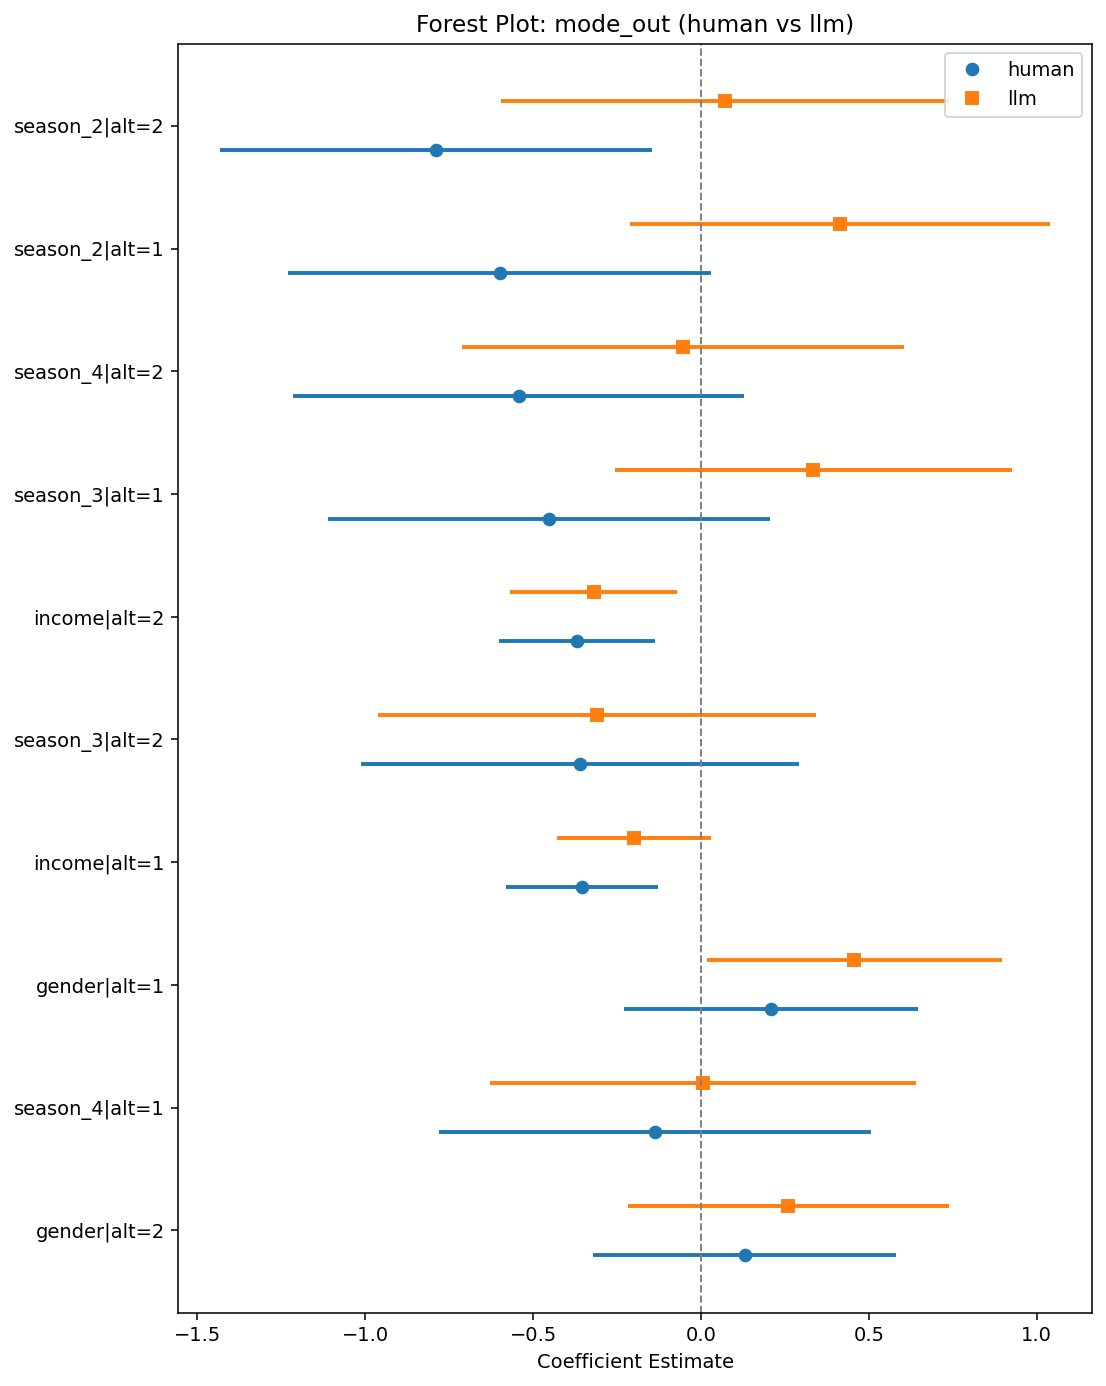

In [19]:
plot_forest_tier4(evals,'mode_out',model_labels=('human', 'llm'))

# Summary

In [20]:
from llm_survey_eval.summary import evaluate_all_tiers,summarise_tier_report

In [21]:
evaluate_all_tiers(human, llm, feature_schema, ordered_features, nominal_features)

Human embedding shape: (500, 27)
LLM embedding shape: (500, 27)


,tier,variable,TV,W1,MeanDiff,VarRatio,MAE,RMSE,MaxAbs,energy_distance,mmd_gaussian,mmd_bandwidth,c2st_auc,DCR,SMR,n_coefs
0,Tier 1,shopping_frequency,0.018,0.022,-0.001647,0.988937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tier 1,leisure_frequency,0.008,0.012,-0.003373,0.999433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tier 1,service_frequency,0.006,0.012,-0.003373,1.010717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tier 1,shopping_satisfaction,0.022,0.022,0.002811,1.014547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tier 1,leisure_satisfaction,0.020,0.020,0.000000,1.006752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Tier 1,service_satisfaction,0.008,0.010,0.000559,1.005103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Tier 1,shopping_mode,0.102,NaN,-0.036051,0.835849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Tier 1,leisure_mode,0.120,NaN,-0.036820,0.801541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Tier 1,service_mode,0.114,NaN,-0.046056,0.868565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tier 2,GLOBAL,NaN,NaN,NaN,NaN,0.025739,0.041305,0.118178,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
print(summarise_tier_report(evaluate_all_tiers(human, llm, feature_schema, ordered_features, nominal_features)))

Human embedding shape: (500, 27)
LLM embedding shape: (500, 27)
LLM vs Human Survey Evaluation Summary
Tier 1 – Descriptive Similarity:
  Average Total Variation (TV): 0.046
  Average Wasserstein Distance (W1): 0.016
  Mean Difference Ratio (|Δμ/μ|): 0.015
  Variance Ratio (LLM/Human): 0.948

Tier 2 – Behavioural Association Consistency:
  Mean Absolute Error: 0.026
  Root Mean Square Error: 0.041
  Max Absolute Difference: 0.118

Tier 3 – Multivariate Behavioural Fidelity:
  Energy Distance: 0.131
  MMD (Gaussian): 0.040
  Classifier AUC (Separability): 0.589

Tier 4 – Inferential Equivalence:
  Average Directional Consistency Rate (DCR): 0.507
  Average Significance Matching Rate (SMR): 0.919

Interpretation Summary:
  - Tier 1 captures marginal distribution realism; low TV/W1 means high fidelity.
  - Tier 2 reflects internal behavioural structure; smaller RMSE indicates closer relational patterns.
  - Tier 3 assesses global realism; high AUC (>0.8) implies LLM data are easily separa